In [1]:
%reload_ext autoreload
%aimport -pandas, -numpy
%autoreload 2
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
from pprint import pprint as pp
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow
from tqdm.auto import tqdm

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    FSMOperator, filterFSM, FSM_splot, FSM_add_Notations, FSM_add_Alarms, FSM_add_Warnings, 
    #FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, 
    #alarms_pareto, warnings_pareto, states_lines,
    #detect_edge_right, detect_edge_left, 
    cvset, load_data, get_cycle_data, get_cycle_data2, figures)
    
cred()
mp = MyPlant(0)
Engine._list_cached_validations();
#mp._fetch_installed_base(); # refresh local installed fleet database

In [2]:
def sfun(x):
    #return all([ ("Forsa Hartmoor" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
    #return all([ ("EWB" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
    #return all([ ("Pforzheim" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
    return all([ ("BMW Landshut 4.10" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T;

In [3]:
motor = fleet.iloc[0]
modes = ['undefined','OFF','MAN','AUTO']
success = [True,False]
#success = [True]
e=Engine.from_fleet(mp,motor)
#pp_from=e['Commissioning Date']
pp_from='2020-02-13 01:10'
pp_to='2020-02-13 12:00'
#pp_to=datetime.now()
fsm = FSMOperator(e, p_from=pp_from, p_to=pp_to)
#TODO:
# - move successtime to run1
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('BMW Landshut 4.10 M1', ['undefined', 'OFF', 'MAN', 'AUTO'], [True, False])

In [4]:
fsm._messages[-3:]

,index,assetId,isPrimary,message,name,severity,timestamp,associatedValues
66,94376,117510,NaN,Exhaust gas scavenging flap closed,1276,600,1581594931203,NaN
67,94375,117510,NaN,Demand exhaust gas scavenging fan off,1278,600,1581594944163,NaN
68,94374,117510,NaN,Exhaust gas scavenging fan operation off,1280,600,1581594944458,NaN


In [ ]:
fsm.restore()
#TODO:
# - store start & endtime, eventually the last 10 messages in self.results
# - in run1 & run2 run the fsm on just the new messages/starts

In [5]:
#fsm.run1(enforce=True, silent=False, successtime=300) # run Finite State Machine
fsm.run1_V2(enforce=True, silent=True, successtime=300) # run Finite State Machine
#fsm.store()

message queue after fill: 36  items
1581556420562 2020-02-13 01:13:40.562000 1231 600 Request module on
1581556420563 2020-02-13 01:13:40.563000 1277 600 Demand exhaust gas scavenging fan on
1581556420665 2020-02-13 01:13:40.665000 1261 600 Demand oil pump (DC) on
1581556420665 2020-02-13 01:13:40.665000 1259 600 Demand oil pump on
1581556420665 2020-02-13 01:13:40.665000 1257 600 Demand engine cooling water pump on
1581556420766 2020-02-13 01:13:40.766000 1262 600 Demand oil pump (DC) off
1581556420766 2020-02-13 01:13:40.766000 1260 600 Demand oil pump off
1581556420866 2020-02-13 01:13:40.866000 1279 600 Exhaust gas scavenging fan operation on
1581556421469 2020-02-13 01:13:41.469000 1273 600 Demand exhaust gas scavenging flap open
1581556422071 2020-02-13 01:13:42.071000 1265 600 Demand gas leakage check gas train 1
1581556423981 2020-02-13 01:13:43.981000 1282 600 Demand engine cooling water preheating pump off
1581556432238 2020-02-13 01:13:52.238000 1266 600 Release from gas lea

In [ ]:
fsm.extra_messages;

In [ ]:
fsm.run2(silent = False)

In [ ]:
fsm.store()
#TODO:
# - check in run1 & run2 if changes were made, if not ... do not physically change the stored file

In [7]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
rdb = rda
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")
pd.DataFrame.from_dict(e.dash, orient='index').T

Starts: 1, Successful: 1, Failed: 0 => 100.0%


,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,BMW Landshut 4.10 M1,M1,U781,624,H01,24,4500.0,24.5,1320090,117510,15306.0,2019-01-07,1157,14149.0,0.0245


In [8]:
#rda = rda[rda['count_alarms'] > 0]
rda[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,True,???,264.86,5.32,18.66,8.15,18.92,138.89,454.79,,,37654.27,98.58,0.0,46.57,0,0


In [9]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (18,12)
dset = [
    {'col':['cumstarttime'],'ylim':(-600,500), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,400)},
    {'col':['startpreparation'],'ylim':(-1000,800)},
    {'col':['hochlauf'],'_ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,6)},
    #{'col':['no'],'ylim':(-100,2000),'color':'rgba(0,0,0,0.3)'},
    {'col':['targetload'],'ylim':(500,5000) },
    {'col':['count_warnings','count_alarms','no'],'ylim':(-1,200), 'color':['rgba(255,165,0,0.3)','rgba(255,0,0,0.3)','rgba(0,0,0,0.1)'] }
    ]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)

In [10]:
def f(x=0):
    global vv; vv = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')} CumStart: {startversuch['cumstarttime']:0.1f}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='90%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='90%'), max=0), Output()), _dom_…

In [11]:
for f in figures:
    print(f, end=', ')
#for doplot in ['actors','lubrication']:
for doplot in ['actors']:
    dmaxlength = None
    dminlength = None
    #dmaxlength = 1200
    #dminlength = 200000
    dset = figures[doplot]
    vset = cvset(mp,dset)
    startversuch = rdb.iloc[vv]; 
    try:
        data = get_cycle_data2(fsm, startversuch, max_length=dmaxlength, min_length=dminlength, cycletime=1, silent=True, p_data=cvset(mp,dset))
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        fig = FSM_splot(fsm, startversuch, data, dset, figsize=(18,10))
        fig = FSM_add_Notations(fig, fsm, startversuch)
        fig = FSM_add_Alarms(fig, fsm, startversuch)
        fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    except Exception as err:
        print(err)

starts_overview, actors, lubrication, von: 13.02.2020 01:13:40 bis: 13.02.2020 11:51:14


In [12]:
import bokeh
from bokeh.models import ColumnDataSource, Label, Text, Span, HoverTool #, Range1d#, LabelSet
from bokeh.plotting import figure, output_file, show

#startversuch = rdb.iloc[vvv];
periodfactor = 3 # times calculated period length
helplinefactor = 0.8 # overlay slope to -fac * end value 
#interestingcycles = [0,1,8, 62, 65, 76, 77, 80, 95, 96, 97, 98, 99, 252, 678] # BMW Landshut M4
interestingcycles = [117] # Forsa Hartmoor M1
#interestingcycles = [0,64, 66, 82] # Forsa Hartmoor M4
#interestingcycles = [0] # Pforzheim M4
#interestingcycles = [17] #
#interestingcycles = [335] # !!! Bautzen M01 T902, Start von: 08.12.2021 13:14:29 bis: 12.12.2021 00:40:40
#interestingcycles = [142] # Bautzen M01 T902, Start von: 04.07.2021 15:57:29 bis: 04.07.2021 21:03:40  => Ende nicht erkannt. 
interestingcycles = [vv] # Bautzen M01 T902
disp_result(rdb.iloc[interestingcycles[0]])

no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,True,???,264.864,5.317,18.658999,8.147,18.915,138.888,454.789999,NaN,NaN,37654.268999,98.58,0.0,46.568999,0,0


In [13]:
# Algorithm visualization
import time
import dmyplant2
dset2 = [{'col':['Power_PowerAct','helpline'], 'ylim':(-1000,12000), 'color':['red','rgba(0,128,0,0.2)'], 'unit':'kW'},
         {'col':['power_diff','power_diff_help'], '_ylim':(0,5000), 'color':['rgba(255,0,0,0.2)','rgba(0,128,0,0.2)'], 'unit':'kW/s'}]
ratedload = fsm._e['Power_PowerNominal']
for i in interestingcycles: 
    #startversuch=fsm.results['starts'][i]
    startversuch=rdb.iloc[i]
    sno = startversuch['no']
    data, xmax, ymax, duration, ramprate = dmyplant2.loadramp_edge_detect(fsm,startversuch, periodfactor=periodfactor, helplinefactor=helplinefactor)
    if not data.empty:
        print(f"Start: {startversuch['no']:3d} xmax: {xmax}, ymax: {ymax:6.0f}, duration: {duration:5.1f}, ramprate: {ramprate / ratedload * 100.0:4.2f} %/s")
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        #data['power_diff_help'] = pd.Series(np.gradient(data['helpline']))
        fig = FSM_splot(fsm, startversuch, data, dset2, figsize=(16,8))
        fig.add_layout(Span(location=0.0,dimension='width',x_range_name='default', y_range_name='0',line_color='black', line_dash='solid', line_alpha=0.4)) 
        fig.add_layout(Span(location=ymax,dimension='width',x_range_name='default', y_range_name='0',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig.add_layout(Span(location=xmax,dimension='height',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig = FSM_add_Notations(fig, fsm, startversuch)
        fig = FSM_add_Alarms(fig, fsm, startversuch)
        fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    else:
        print(f"Start: {startversuch['no']:3d} no data, no improvement possible.")

Start:   0 xmax: 2020-02-13 01:22:30, ymax:   3154, duration: 213.5, ramprate: 0.33 %/s
von: 13.02.2020 01:13:40 bis: 13.02.2020 11:51:14


In [14]:
sv=fsm.results['starts'][startversuch['no']]

#phases = [k for k in sv['startstoptiming''].keys() if k != 'targetoperation_org']
phases = list(sv['startstoptiming''].keys())
fsm._harvest_timings(sv, phases)
sv['loadramp']

138.888

In [15]:
from pprint import pformat as pf
durations = { ph:pd.Timedelta(sv['startstoptiming''][ph][-1]['end'] - sv['startstoptiming''][ph][-1]['start']).total_seconds() for ph in phases}
#print(pf(durations))
durations['cumstarttime'] = sum([v for k,v in durations.items() if k in ['startpreparation','starter','speedup','idle','synchronize','loadramp']])
durations

{'startpreparation': 264.864,
 'starter': 5.317,
 'speedup': 18.658999,
 'idle': 8.147,
 'synchronize': 18.915,
 'loadramp': 138.888,
 'targetoperation': 37654.268999,
 'rampdown': 98.58,
 'coolrun': 0.0,
 'runout': 46.568999,
 'targetoperation_org': 37654.268999,
 'cumstarttime': 454.78999899999997}

In [ ]:
#pp(rdb.iloc[vv].to_dict())
sv;

### State Changes and trigger messages

In [16]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=True)):
    print(f"{i:3} {v}")

  0 * |0000| LST 13.02 01:13:40 LS  standstill        | CSS 13.02 01:13:40 CS  startpreparation  | off | ???   | 600 13.02.2020 01:13:40 1231 Request module on
  1 * |0001| LST 13.02 01:13:40 LS  startpreparation  | CSS 13.02 01:18:05 CS  starter           | on  | ???   | 600 13.02.2020 01:18:05 1249 Starter on
  2 * |0001| LST 13.02 01:18:05 LS  starter           | CSS 13.02 01:18:10 CS  speedup           | on  | ???   | 600 13.02.2020 01:18:10 3225 Ignition on
  3 * |0001| LST 13.02 01:18:10 LS  speedup           | CSS 13.02 01:18:29 CS  idle              | on  | ???   | 600 13.02.2020 01:18:29 2124 Idle
  4 * |0001| LST 13.02 01:18:29 LS  idle              | CSS 13.02 01:18:37 CS  synchronize       | on  | ???   | 600 13.02.2020 01:18:37 2139 Request Synchronization
  5 * |0001| LST 13.02 01:18:37 LS  synchronize       | CSS 13.02 01:18:56 CS  loadramp          | on  | ???   | 600 13.02.2020 01:18:56 1235 Generator CB closed
  6 * |0001| LST 13.02 01:18:56 LS  loadramp          | CS

### State Changes, Trigger Messenges and everything in between 

In [17]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=False)):
    print(f"{i:3} {v}")

  0 * |0000| LST 13.02 01:13:40 LS  standstill        | CSS 13.02 01:13:40 CS  startpreparation  | off | ???   | 600 13.02.2020 01:13:40 1231 Request module on
  1   |0001| LST 13.02 01:13:40 LS  standstill        | CSS 13.02 01:13:40 CS  startpreparation  | on  | ???   | 600 13.02.2020 01:13:40 1277 Demand exhaust gas scavenging fan on
  2   |0001| LST 13.02 01:13:40 LS  standstill        | CSS 13.02 01:13:40 CS  startpreparation  | on  | ???   | 600 13.02.2020 01:13:40 1261 Demand oil pump (DC) on
  3   |0001| LST 13.02 01:13:40 LS  standstill        | CSS 13.02 01:13:40 CS  startpreparation  | on  | ???   | 600 13.02.2020 01:13:40 1259 Demand oil pump on
  4   |0001| LST 13.02 01:13:40 LS  standstill        | CSS 13.02 01:13:40 CS  startpreparation  | on  | ???   | 600 13.02.2020 01:13:40 1257 Demand engine cooling water pump on
  5   |0001| LST 13.02 01:13:40 LS  standstill        | CSS 13.02 01:13:40 CS  startpreparation  | on  | ???   | 600 13.02.2020 01:13:40 1262 Demand oil pum

,startpreparation,speedup,idle,synchronize,loadramp,targetload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,1.00,1.00,1.00,1.00,1.00,0.0,0.0,1.00,1.00,1.00,1.0,1.00
mean,264.86,18.66,8.15,18.92,138.89,NaN,NaN,454.79,37654.27,98.58,0.0,46.57
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,264.86,18.66,8.15,18.92,138.89,NaN,NaN,454.79,37654.27,98.58,0.0,46.57
25%,264.86,18.66,8.15,18.92,138.89,NaN,NaN,454.79,37654.27,98.58,0.0,46.57
50%,264.86,18.66,8.15,18.92,138.89,NaN,NaN,454.79,37654.27,98.58,0.0,46.57
75%,264.86,18.66,8.15,18.92,138.89,NaN,NaN,454.79,37654.27,98.58,0.0,46.57
max,264.86,18.66,8.15,18.92,138.89,NaN,NaN,454.79,37654.27,98.58,0.0,46.57


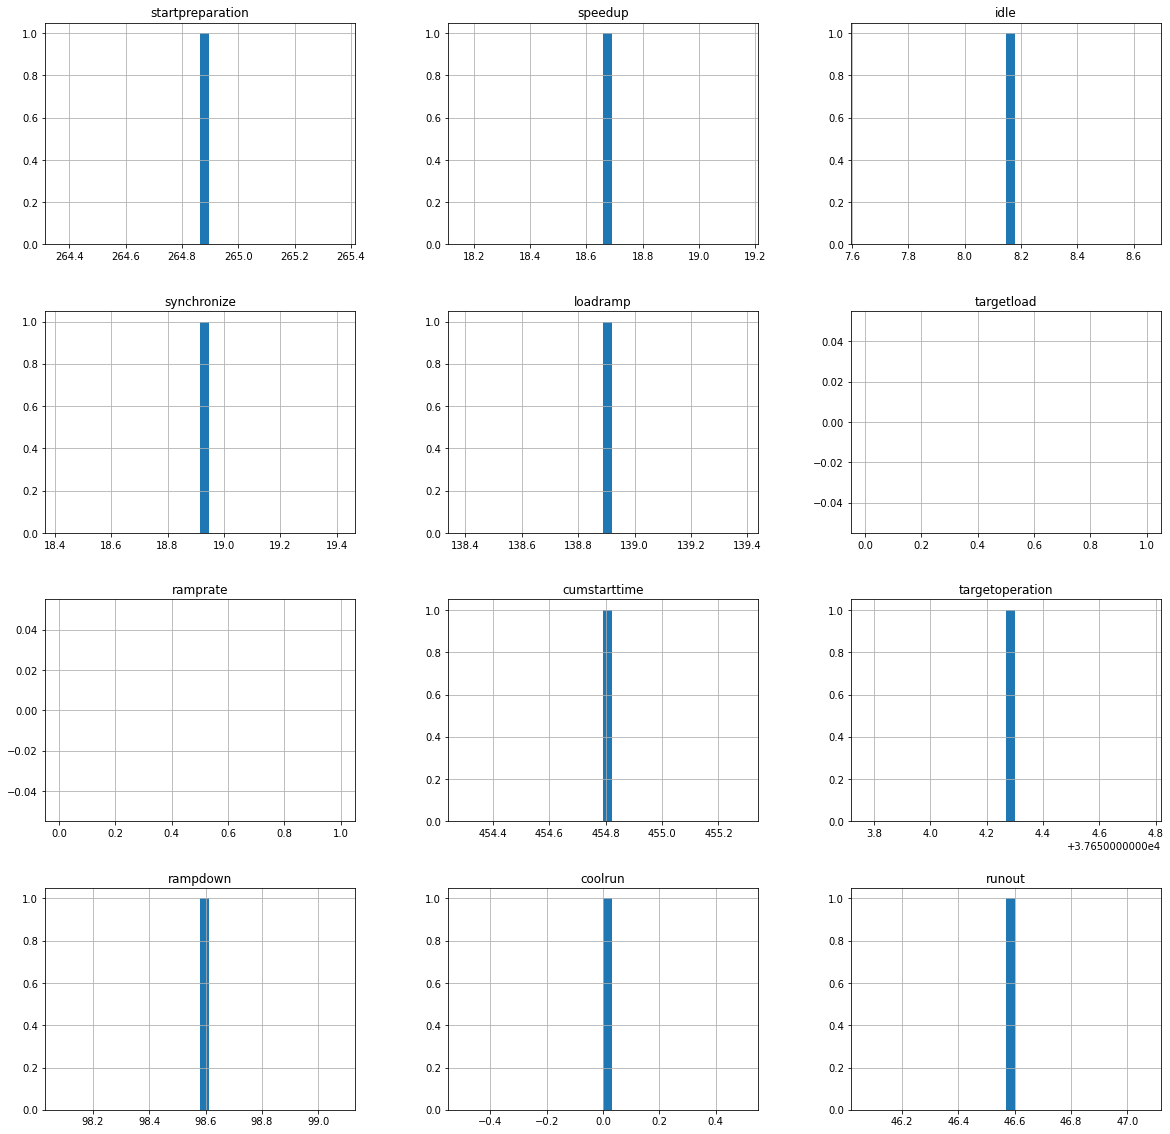

In [18]:
rdb = rda
vec = ['startpreparation','speedup','idle','synchronize','loadramp','targetload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
#ax_list[0][2].set_xlim((0,10))
#display(rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [ ]:
import time
dset2 = [{'col':['Power_PowerAct','helpline'], 'ylim':(-1000,12000), 'color':['red','rgba(0,128,0,0.2)'], 'unit':'kW'},
         {'col':['power_diff','power_diff_help'], '_ylim':(0,5000), 'color':['rgba(255,0,0,0.2)','rgba(0,128,0,0.2)'], 'unit':'kW/s'}]
ratedload = fsm._e['Power_PowerNominal']
t0 = time.time()
for i, startversuch in rdb[-3:].iterrows() : 
#for i, startversuch in tqdm(rdb.iterrows(), total=rdb.shape[0], ncols=80, mininterval=1, unit=' starts', desc="FSM Run2"):
    data, xmax, ymax, duration, ramprate = dmyplant2.loadramp_edge_detect(fsm,startversuch)
    if not data.empty:
        print(f"Start: {startversuch['no']:3d} xmax: {xmax}, ymax: {ymax:6.0f}, duration: {duration:5.1f}, ramprate: {ramprate / ratedload * 100.0:4.2f} %/s")
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        #data['power_diff_help'] = pd.Series(np.gradient(data['helpline']))
        fig = FSM_splot(fsm, startversuch, data, dset2, figsize=(14,6))
        fig.add_layout(Span(location=0.0,dimension='width',x_range_name='default', y_range_name='0',line_color='black', line_dash='solid', line_alpha=0.4)) 
        fig.add_layout(Span(location=ymax,dimension='width',x_range_name='default', y_range_name='0',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig.add_layout(Span(location=xmax,dimension='height',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig = FSM_add_Notations(fig, fsm, startversuch)
        #fig = FSM_add_Alarms(fig, fsm, startversuch)
        #fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    else:
        print(f"Start: {startversuch['no']:3d} no data, no improvement possible.")
t1 = time.time()
print(f"{(t1-t0):4.1f} sec")    

In [ ]:
#currently there is a bug in the plotly figure code ?
from dowork import plot_plotly
fig2 = plot_plotly(fsm, data, startversuch, cvset(mp,dset), dset, dfigsize=(15,9))
fig2.show(config={'scrollZoom': True})

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)